# 통신사 고객 분석을 통한 고객 이탈 예측

#### 데이터 

<a href = 'https://www.kaggle.com/datasets/sibelius5/telco-customer-churn?select=Telco_customer_churn_cleaned.csv' > Kaggle : Telecom Custom Churn</a>

<a href = 'https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113'>IBM : Business Analytics </a>

#### 데이터 DESC
샘플 데이터는 허구의 통신사 회사의 고객 이탈을 여러 가지 가능한 요인에 기반으로 추적한 것입니다. <P>
이탈 열은 해당 고객이 지난 한 달 이내에 떠났는지 여부를 나타냅니다. 다른 열에는 성별, 부양 가족, 월별 <P>
요금 및 각 고객이 가진 서비스 유형에 대한 정보가 포함됩니다. 출처: IBM.<P>

### 1. 데이터 전처리

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
import koreanize_matplotlib # 한글설정 라이브러리 
import plotly.express as px

%matplotlib inline 

In [2]:
data = pd.read_csv('Telco_customer_churn_cleaned.csv')
data.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Streaming Music,Premium Tech Support,Unlimited Data,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Category
0,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Yes,0.0,0,20.94,129.09,1,Churned,Competitor
1,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Yes,0.0,0,18.24,169.89,2,Churned,Other


- Yes, No 카테고리 컬럼들도 1과 0으로 변경한다. 
- 서비스 컬럼 중 'No Phone Serviece' , 'No internet Serviece'  데이터를 'No' 로 변경하여 ('Yes', 'No') 카테고리로 로 맞춰준다
- Contract 컬럼의 계약 유형도 개월수 데이터로 변경해준다 - Month-to-month : 1, One year : 12, Two year : 24, 


In [3]:
# No internet service -> No로 통일
data.loc[data['InternetService']=='No', ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']] = 'No'

# DSL, Fiber optic -> Yes로 통일
data['InternetService'] = data['InternetService'].replace(['DSL', 'Fiber optic'], 'Yes') 

# No phone service -> No로 통일
data.loc[data['PhoneService']=='No', 'MultipleLines'] = 'No'

In [4]:
# Yes, No 문자열 데이터 -> 1과 0로 수정
target_cols = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn', 
                'Under 30', 'Married', 'Referred a Friend','Streaming Music', 
                'Premium Tech Support', 'Unlimited Data', 'InternetService']

for idx, row in data.iterrows():
    for col in target_cols:
        if (row[col] == 'Yes'):
            data.loc[idx, col] = 1
        elif (row[col] == 'No'):
            data.loc[idx, col] = 0

data[target_cols] = data[target_cols].astype('int64')

In [5]:
# Month-to-month:1, One year:12, Two year:24 로 변경
data.loc[data["Contract"]=='Month-to-month', "Contract"] = 1
data.loc[data["Contract"]=='One year', "Contract"] = 12
data.loc[data["Contract"]=='Two year', "Contract"] = 24

data["Contract"] = data["Contract"].astype('int64')

In [6]:
# Customer Status에 'stayed'와 'churned' 데이터만 남기기
data = data[data['Customer Status']!='Joined']

In [7]:
# 불필요한 컬럼 삭제
data.drop(columns=['customerID', 'Partner', 'churn_rate', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude'], inplace=True)


In [8]:
# 컬럼 순서 정렬
data = data[[
    'gender', 'Age', 'Under 30', 'SeniorCitizen', 'Dependents', 'Married',
    'Contract', 'tenure', 'Referred a Friend', 'Number of Referrals', 'Offer',
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies', 'Streaming Music', 'Premium Tech Support', 'Unlimited Data', 
    'Avg Monthly GB Download', 'Avg Monthly Long Distance Charges', 'Total Extra Data Charges', 'Total Long Distance Charges', 
    'MonthlyCharges', 'TotalCharges', 'PaymentMethod', 'PaperlessBilling', 'Total Refunds', 'Total Revenue', 
    'Customer Status', 'Churn Reason', 'Churn Category', 'Satisfaction Score', 'CLTV', 'Churn', 'Count'
]]

In [9]:
# 컬럼명 수정
data.columns = [
    'gender', 'age', 'under30', 'senior', 'dependents', 'married',
    'contract', 'tenure', 'referred_friend', 'referrals_num', 'offer',
    'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 
    'streaming_tv', 'streaming_movies', 'streaming_music', 'premium_tech_support', 'unlimited_data', 
    'avg_monthly_GBdownload', 'avg_monthly_longDistance_charges', 'total_extraData_charges', 'total_longDistance_charges', 
    'monthly_charges', 'total_charges', 'payment_method', 'paperless_billing', 'total_refunds', 'total_revenue', 
    'customer_status', 'churn_reason', 'churn_category', 'satisfaction_score', 'CLTV', 'churn', 'count'
]

In [10]:
data.head(2)

,gender,age,under30,senior,dependents,married,contract,tenure,referred_friend,referrals_num,...,paperless_billing,total_refunds,total_revenue,customer_status,churn_reason,churn_category,satisfaction_score,CLTV,churn,count
0,Male,37,0,0,0,0,1,2,0,0,...,1,0.0,129.09,Churned,Competitor made better offer,Competitor,1,3239,1,1
1,Female,19,1,0,0,0,1,2,0,0,...,1,0.0,169.89,Churned,Moved,Other,2,2701,1,1


In [11]:
len(data.columns), data.columns

(40,
 Index(['gender', 'age', 'under30', 'senior', 'dependents', 'married',
        'contract', 'tenure', 'referred_friend', 'referrals_num', 'offer',
        'phone_service', 'multiple_lines', 'internet_service',
        'online_security', 'online_backup', 'device_protection', 'tech_support',
        'streaming_tv', 'streaming_movies', 'streaming_music',
        'premium_tech_support', 'unlimited_data', 'avg_monthly_GBdownload',
        'avg_monthly_longDistance_charges', 'total_extraData_charges',
        'total_longDistance_charges', 'monthly_charges', 'total_charges',
        'payment_method', 'paperless_billing', 'total_refunds', 'total_revenue',
        'customer_status', 'churn_reason', 'churn_category',
        'satisfaction_score', 'CLTV', 'churn', 'count'],
       dtype='object'))

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6589 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gender                            6589 non-null   object 
 1   age                               6589 non-null   int64  
 2   under30                           6589 non-null   int64  
 3   senior                            6589 non-null   int64  
 4   dependents                        6589 non-null   int64  
 5   married                           6589 non-null   int64  
 6   contract                          6589 non-null   int64  
 7   tenure                            6589 non-null   int64  
 8   referred_friend                   6589 non-null   int64  
 9   referrals_num                     6589 non-null   int64  
 10  offer                             6589 non-null   object 
 11  phone_service                     6589 non-null   int64  
 12  multip

In [13]:
# 결측치 확인
print(data.columns[data.isnull().any()])
# 이탈 이유가 없는 고객은 'None' 값으로 대체 
data['churn_reason'].fillna('None', inplace=True)

Index(['churn_reason'], dtype='object')


### EDA 

In [14]:
# 이탈 고객과 미이탈 고객의 dataframe 각각 생성
churn_y = data[data['churn']==1]
churn_n = data[data['churn']==0]

In [15]:
# dataframe 이름과 컬럼명을 넣으면 항목별 비율 반환
def get_percent(df_name, column_name):
    return round(df_name[column_name].value_counts() / len(df_name) * 100, 1)

In [16]:
# dataframe 이름과 컬럼명을 넣으면 항목별 비율을 피벗테이블로 반환
def pivot_percent(df_name, column_name):
    pivot_table = df_name.pivot_table(index=column_name, columns='churn', values='count', aggfunc=np.sum) / len(df_name) * 100
    
    return round(pivot_table, 1)

#### 고객 이탈률 확인 
- NO : 4720명 (73.4 %)
- YES : 1869명 (26.6 %) 

In [17]:
data.churn.value_counts()

0    4720
1    1869
Name: churn, dtype: int64

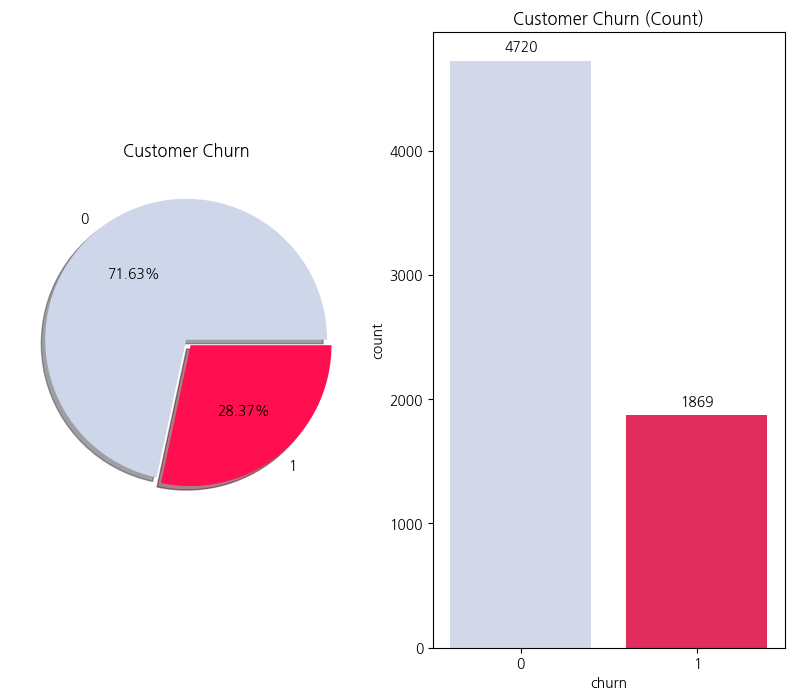

In [18]:
f, ax = plt.subplots(1, 2, figsize = (10, 8)) 

data['churn'].value_counts().plot.pie(explode = [0, 0.05], # 각 조각 사이 거리
                                            autopct='%1.2f%%', # 퍼센트 표시
                                            ax=ax[0], # 첫번째 위치에 그리기 
                                            colors=['#CED7EA', '#ff0f4f'],
                                            shadow=True) 


ax[0].set_title('Customer Churn')
ax[0].set_ylabel('') 

sns.countplot(data=data, x='churn', ax=ax[1], palette=['#CED7EA','#ff0f4f'])
ax[1].set_title('Customer Churn (Count)')
for p in ax[1].patches: # 데이터 텍스트 표시 
    ax[1].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# ax[1].set_xticklabels(['No', 'Yes'])

plt.rcParams['font.size'] = 12
plt.show()

### 성별 따른 이탈률
- 성별 데이터가 고르게 분포되어 있고 성별에 따른 이탈률도 유사하다
- 고객 이탈에 큰 영향을 주지 않는다 

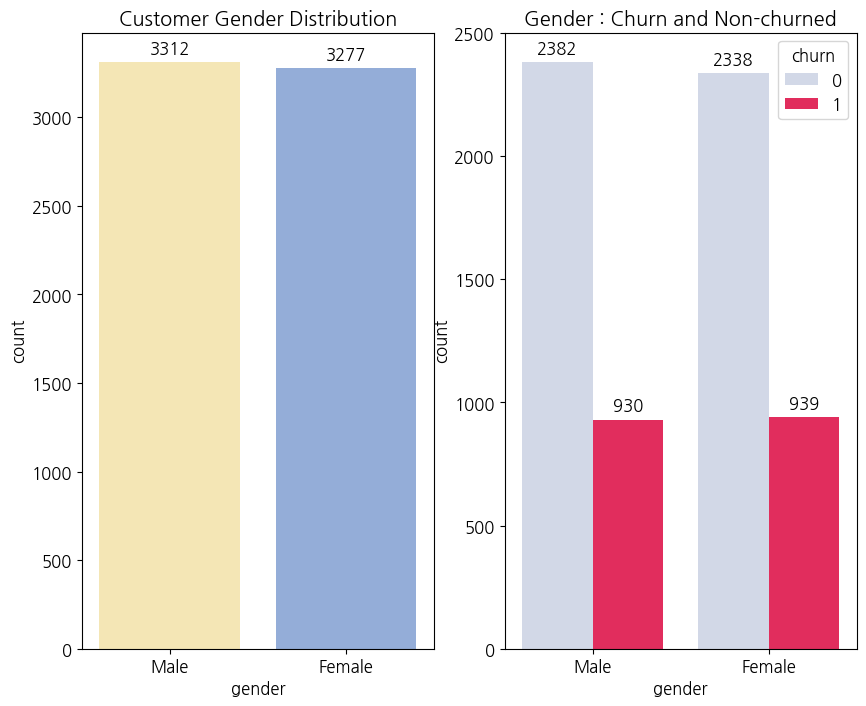

In [19]:
f, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].set_title('Customer Gender Distribution')
sns.countplot(x='gender', data=data, ax=ax[0], palette=['#ffecab', '#89aae3'])
for p in ax[0].patches: # 데이터 텍스트 표시  
    ax[0].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 

ax[1].set_title('Gender : Churn and Non-churned')
sns.countplot(x='gender', data=data, hue='churn', ax=ax[1], palette=['#CED7EA', '#ff0f4f'])
for p in ax[1].patches: # 데이터 텍스트 표시 
    ax[1].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.rcParams['font.size'] = 12
plt.show()

### 결혼여부에 따른 이탈률 
- 고객 데이터의 결혼 여부는 No가 미세하게 더 많다
- 결혼을 하지않은 사람의 이탈률이 더 높으나 큰 영향은 미치지 않는다

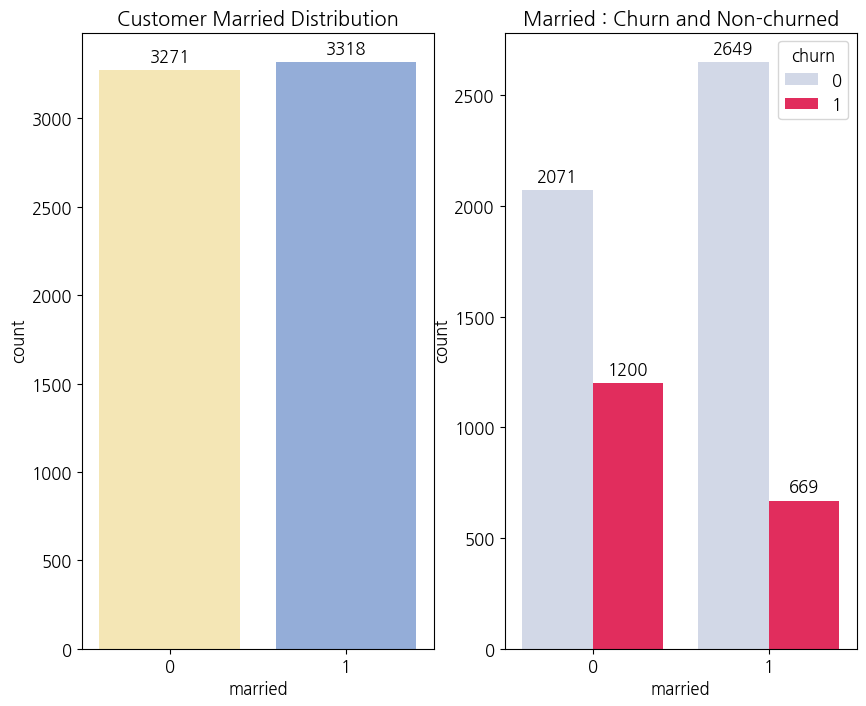

In [20]:
f, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].set_title('Customer Married Distribution')
sns.countplot(x='married', data=data, ax=ax[0], palette=['#ffecab', '#89aae3'])
for p in ax[0].patches: # 데이터 텍스트 표시  
    ax[0].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 

ax[1].set_title('Married : Churn and Non-churned')
sns.countplot(x='married', data=data, hue='churn', ax=ax[1], palette=['#CED7EA', '#ff0f4f'])
# ax[1].set_xlabel('Churn')
for p in ax[1].patches: # 데이터 텍스트 표시 
    ax[1].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.rcParams['font.size'] = 12
plt.show()

### 고객 나이 분포 확인 
65세 이전까지는 모든 나이대의 분포 차이가 크지않아 보인다

In [21]:
# 고객 나이 분포
fig = px.histogram(data, x='age')

fig.update_layout(
    width=1500,  
    height=500, 
)
fig.show()

65세 이상은 65세 이하보다 이탈률이 높다 

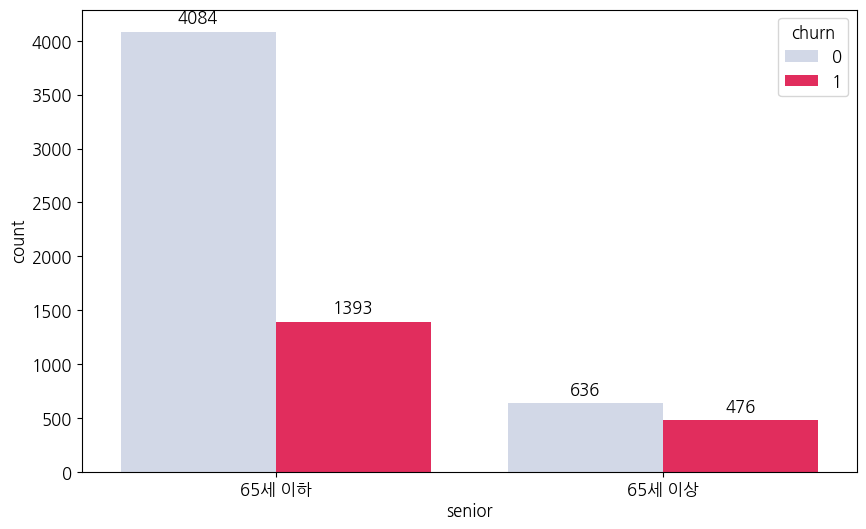

In [22]:
# 65세 이상 데이터 확인

plt.figure(figsize=(10,6))
ax = sns.countplot(x='senior', data=data, hue='churn', palette=['#CED7EA', '#ff0f4f'])
for p in ax.patches: # 데이터 텍스트 표시 
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax.set_xticklabels(['65세 이하', '65세 이상'])
plt.rcParams['font.size'] = 12
plt.show()

#### 계약 유형별 이탈률
- 'Month-to-month', 'Two year', 'One year' 유형으로 나뉜다 
- 상대적으로 Month-to-Month 계약의 이탈률이 가장 높다 

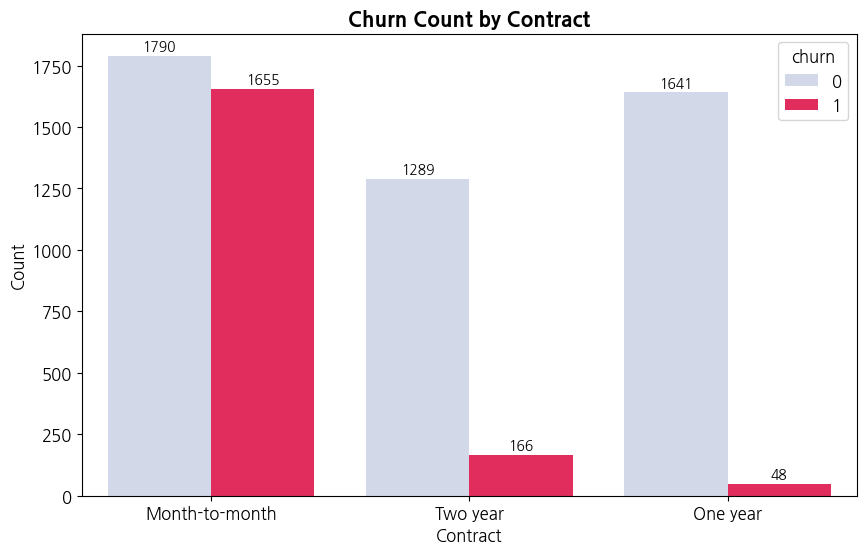

In [23]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=data, x='contract', hue='churn', palette=['#CED7EA', '#ff0f4f'])

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height+10), ha='center', va='bottom', fontsize=10)

plt.xlabel('Contract', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Churn Count by Contract', fontsize=15, weight='bold')
ax.set_xticklabels(['Month-to-month', 'Two year', 'One year'])
plt.show()

### 통신사 이용 기간
이탈 고객의 통신사 이용 기간은 짧은 편이다.


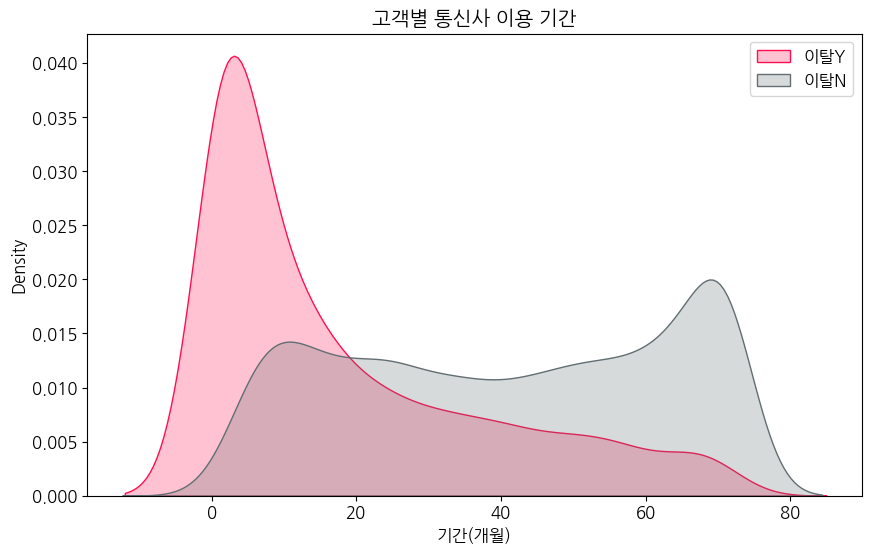

In [24]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(churn_y.tenure, color="#ff0f4f", fill = True)
ax = sns.kdeplot(churn_n.tenure, ax =ax, color="#626e72", fill= True)
ax.legend(["이탈Y","이탈N"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('기간(개월)')
ax.set_title('고객별 통신사 이용 기간');
plt.show()

### 통신사의 마케팅 제안 수락 여부
통신사의 제안을 거부한 고객은 이탈 고객의 56.2%, 유지 고객의 54%를 차지한다.

In [25]:
offer_percent = pd.concat([pivot_percent(churn_y, 'offer'), pivot_percent(churn_n, 'offer')], axis=1)
offer_percent

churn,1,0
offer,,
None,56.2,54.0
Offer A,1.9,10.3
Offer B,5.4,15.3
Offer C,5.1,6.8
Offer D,8.6,9.3
Offer E,22.8,4.3


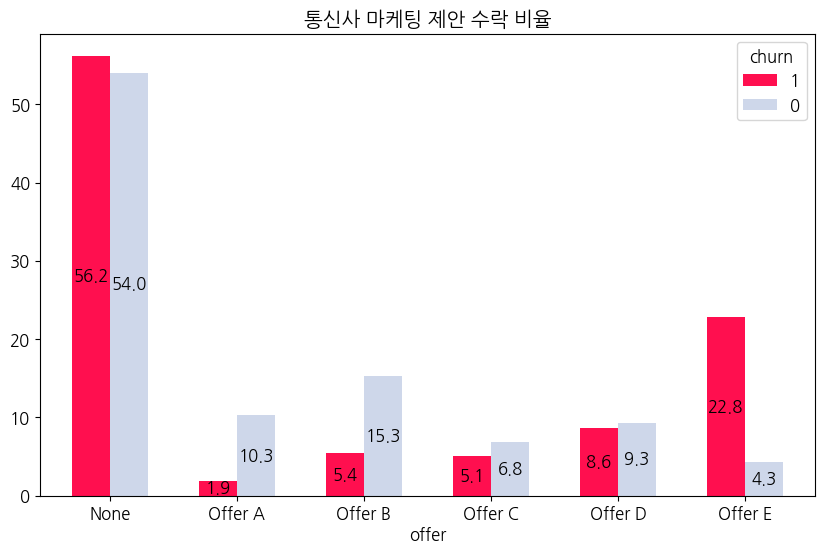

In [26]:
ax = offer_percent.plot(kind="bar", figsize=(10,6), width=0.6, color = ['#ff0f4f','#CED7EA'])

for c in ax.containers:
    labels = [ x.get_height() for x in c ]
    ax.bar_label(c, labels= np.round(labels,1), label_type='center')
    
plt.rcParams['font.size'] = 12
plt.title('통신사 마케팅 제안 수락 비율')
plt.xticks(rotation=0)
plt.show()

### 부가 서비스 

#### 1. phone_service
phone_service는 이탈 여부와 상관없이 90% 이상 사용한다.


In [27]:
phone_service_pct = pd.concat([pivot_percent(churn_y, 'phone_service'), pivot_percent(churn_n, 'phone_service')], axis=1)
phone_service_pct


churn,1,0
phone_service,,
0,9.1,10.0
1,90.9,90.0


In [28]:
# pivot_percent 그래프 생성 함수 

def draw_pct_plot(df, title, x_label, xtick_labels):
    ax = df.plot(kind="bar",figsize=(8,6), width=0.4, color = ['#ff0f4f','#CED7EA'])
    for c in ax.containers:
        labels = [ x.get_height() for x in c ]
        ax.bar_label(c, labels= np.round(labels,1), label_type='center')
        
    plt.rcParams['font.size'] = 12
    plt.title(title)
    plt.xticks(rotation=0)
    ax.set_xticklabels(xtick_labels)
    plt.xlabel(x_label)
    plt.show()

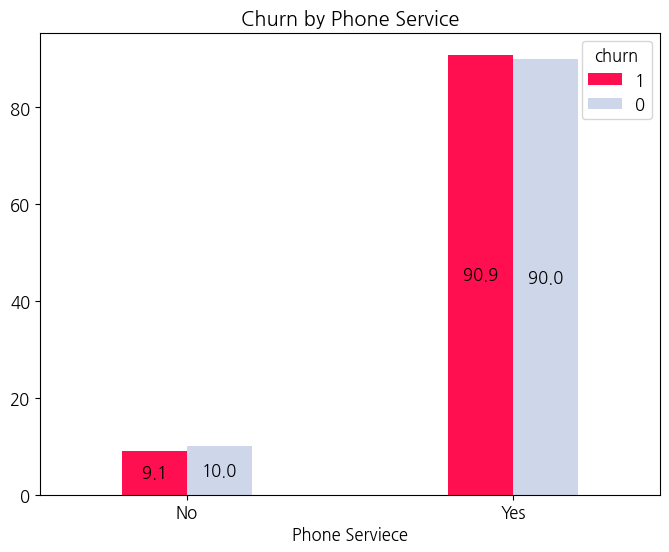

In [29]:
draw_pct_plot(phone_service_pct, 'Churn by Phone Service','Phone Serviece', ['No', 'Yes'] )

#### 2. multiple_lines
multiple_lines 이용 비율은 이탈 고객(45.5%)과 유지 고객(44%)에서 큰 차이가 없다.


In [30]:
multiline_pct = pd.concat([pivot_percent(churn_y, 'multiple_lines'), pivot_percent(churn_n, 'multiple_lines')], axis=1)
multiline_pct


churn,1,0
multiple_lines,,
0,54.5,56.0
1,45.5,44.0


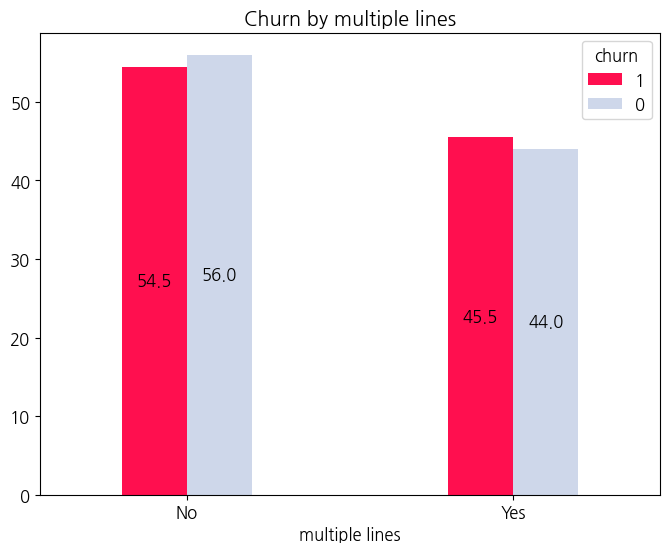

In [31]:
draw_pct_plot(multiline_pct, 'Churn by multiple lines', 'multiple lines',['No', 'Yes'] )

### 3. internet_service
이탈 고객의 대부분(94%)은 인터넷 서비스를 사용중이다.


In [32]:
internet_serviece_pct = pd.concat([pivot_percent(churn_y, 'internet_service'), pivot_percent(churn_n, 'internet_service')], axis=1)
internet_serviece_pct

churn,1,0
internet_service,,
0,6.0,26.1
1,94.0,73.9


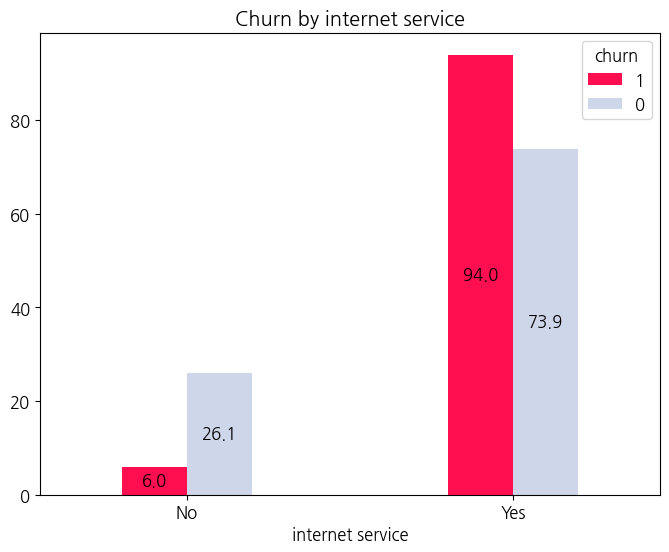

In [33]:
draw_pct_plot(internet_serviece_pct, 'Churn by internet service', 'internet service', ['No', 'Yes'] )

#### 4. online_security
전체 29.9%의 고객이 온라인 보안 서비스를 사용한다.

이탈 고객보다 유지 고객의 온라인 보안 서비스 사용률이 높다.


In [34]:
online_security_ptc = pd.concat([pivot_percent(churn_y, 'online_security'), pivot_percent(churn_n, 'online_security')], axis=1)
online_security_ptc


churn,1,0
online_security,,
0,84.2,64.4
1,15.8,35.6


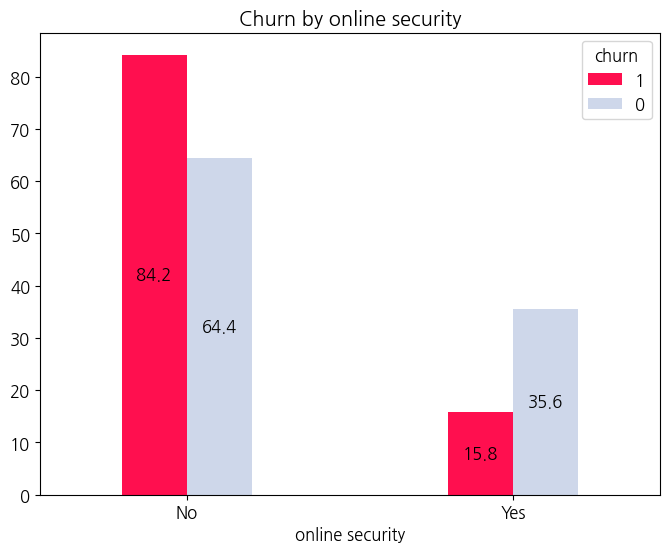

In [35]:
draw_pct_plot(online_security_ptc, 'Churn by online security', 'online security', ['No', 'Yes'] )

#### 5. online_backup
전체 36%의 고객이 온라인 백업 서비스를 사용한다.

이탈 고객보다 유지 고객의 온라인 백업 서비스 사용률이 높다.

In [36]:
online_backup_ptc = pd.concat([pivot_percent(churn_y, 'online_backup'), pivot_percent(churn_n, 'online_backup')], axis=1)
online_backup_ptc

churn,1,0
online_backup,,
0,72.0,60.8
1,28.0,39.2


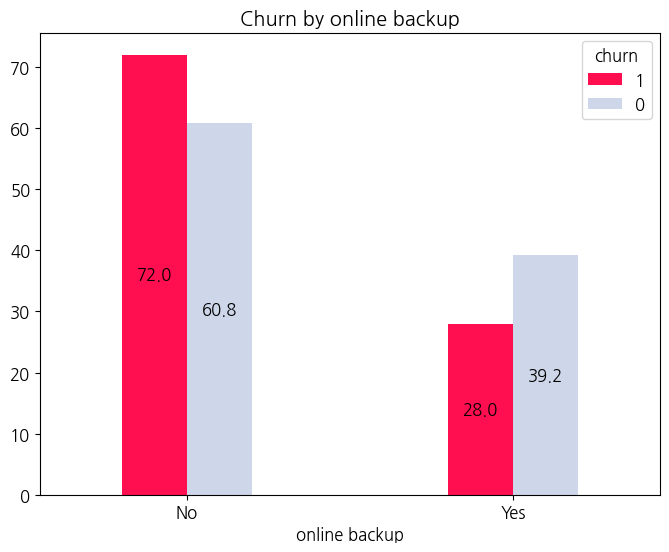

In [37]:
draw_pct_plot(online_backup_ptc, 'Churn by online backup', 'online backup', ['No', 'Yes'] )


#### 6. device_protection
전체 36.3%의 고객이 기기 보호 서비스를 사용한다.

이탈 고객보다 유지 고객의 기기 보호 서비스 사용률이 높다.

In [38]:
device_protection_ptc = pd.concat([pivot_percent(churn_y, 'device_protection'), pivot_percent(churn_n, 'device_protection')], axis=1)
device_protection_ptc

churn,1,0
device_protection,,
0,70.8,60.9
1,29.2,39.1


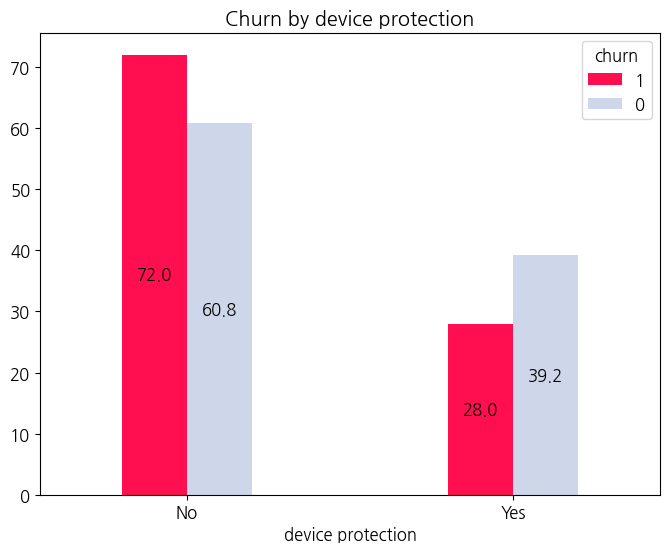

In [39]:
draw_pct_plot(online_backup_ptc, 'Churn by device protection', 'device protection', ['No', 'Yes'] )


#### 7. tech_support
전체 30.3%의 고객이 기술 지원 서비스를 사용한다.

이탈 고객보다 유지 고객의 기술 지원 서비스 사용률이 높다.

In [40]:
tech_ptc = pd.concat([pivot_percent(churn_y, 'tech_support'), pivot_percent(churn_n, 'tech_support')], axis=1)
tech_ptc

churn,1,0
tech_support,,
0,83.4,64.3
1,16.6,35.7


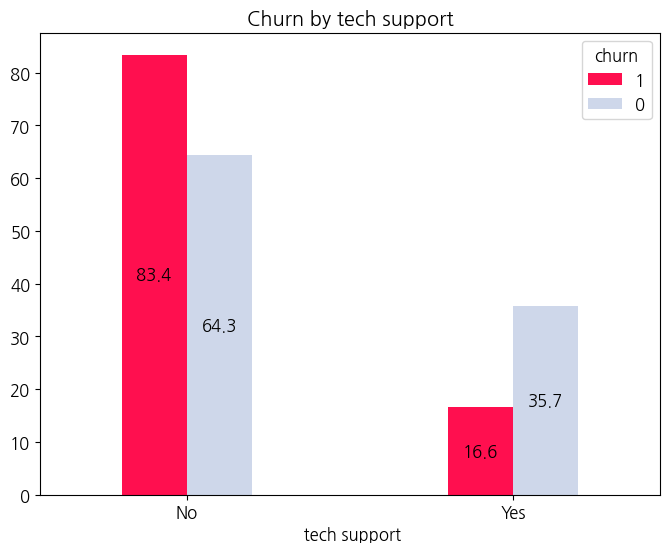

In [41]:
draw_pct_plot(tech_ptc, 'Churn by tech support', ' tech support', ['No', 'Yes'] )


#### 8. streaming_tv
전체 40.3%의 고객이 티비 서비스를 사용한다.

이탈 고객의 티비 서비스 사용률이 유지 고객보다 높다


In [42]:
streaming_ptc = pd.concat([pivot_percent(churn_y, 'streaming_tv'), pivot_percent(churn_n, 'streaming_tv')], axis=1)
streaming_ptc


churn,1,0
streaming_tv,,
0,56.4,60.9
1,43.6,39.1


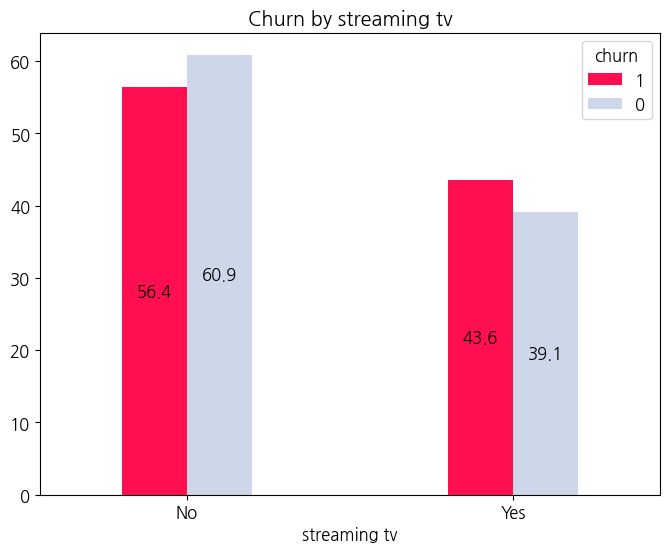

In [43]:
draw_pct_plot(streaming_ptc, 'Churn by streaming tv', 'streaming tv', ['No', 'Yes'] )


#### 9. streaming_movies
전체 40.7%의 고객이 영화 서비스를 사용한다.

이탈 고객의 영화 서비스 사용률이 유지 고객보다 높다.

In [44]:
streaming_mv_ptc = pd.concat([pivot_percent(churn_y, 'streaming_movies'), pivot_percent(churn_n, 'streaming_movies')], axis=1)
streaming_mv_ptc


churn,1,0
streaming_movies,,
0,56.2,60.5
1,43.8,39.5


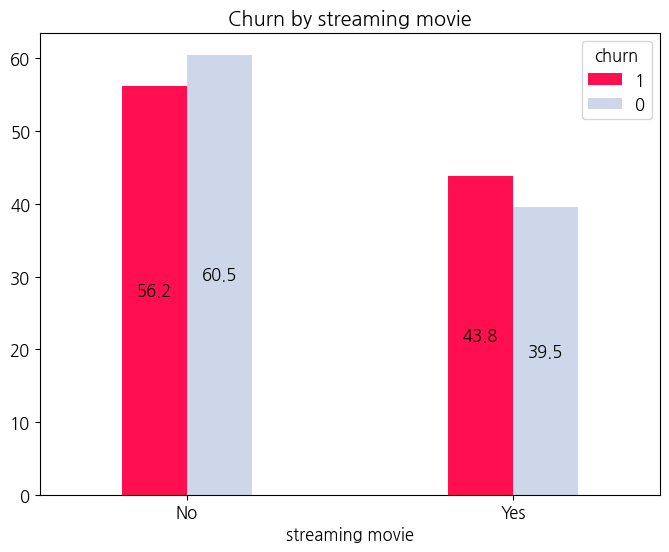

In [45]:
draw_pct_plot(streaming_mv_ptc, 'Churn by streaming movie', 'streaming movie', ['No', 'Yes'] )


#### 10. streaming_music
전체 37%의 고객이 음악 서비스를 사용한다.

이탈 고객의 음악 서비스 사용률이 유지 고객보다 높다.

In [46]:
streaming_music_ptc = pd.concat([pivot_percent(churn_y, 'premium_tech_support'), pivot_percent(churn_n, 'premium_tech_support')], axis=1)
streaming_music_ptc

churn,1,0
premium_tech_support,,
0,83.4,64.3
1,16.6,35.7


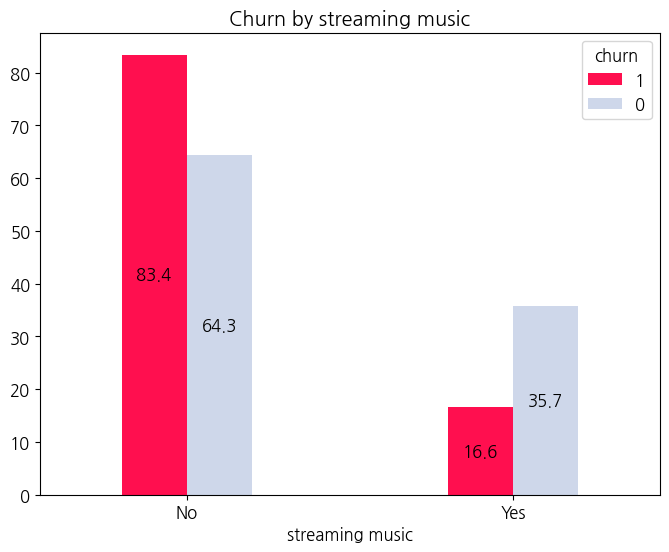

In [47]:
draw_pct_plot(streaming_music_ptc, 'Churn by streaming music', 'streaming music', ['No', 'Yes'] )


#### 11. premium_tech_support
전체 30.3%의 고객이 고급 기술 지원 서비스를 사용한다.

이탈 고객보다 유지 고객의 고급 기술 지원 서비스 사용률이 높다.

In [48]:
premium_tech_ptc = pd.concat([pivot_percent(churn_y, 'premium_tech_support'), pivot_percent(churn_n, 'premium_tech_support')], axis=1)
premium_tech_ptc

churn,1,0
premium_tech_support,,
0,83.4,64.3
1,16.6,35.7


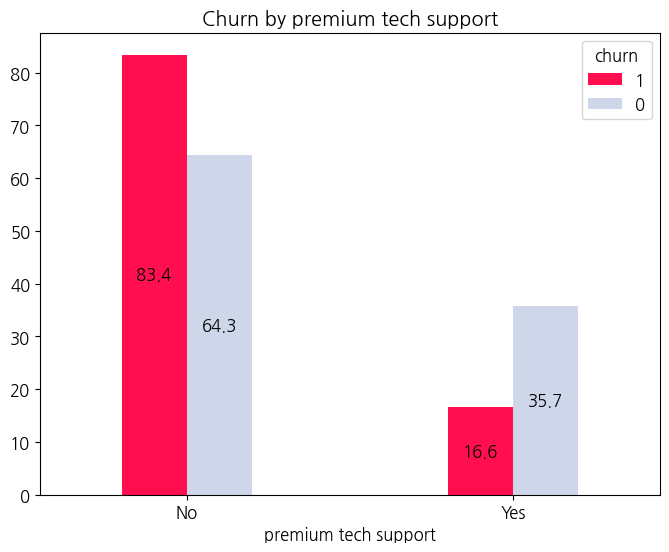

In [49]:
draw_pct_plot(premium_tech_ptc, 'Churn by premium tech support', 'premium tech support', ['No', 'Yes'] )


#### 12. unlimited_data
전체 68.6%의 고객이 데이터 무제한 서비스를 사용한다.

이탈 고객의 데이터 무제한 서비스 이용률이 유지 고객보다 높다.

In [50]:
unlimited_ptc = pd.concat([pivot_percent(churn_y, 'unlimited_data'), pivot_percent(churn_n, 'unlimited_data')], axis=1)
unlimited_ptc

churn,1,0
unlimited_data,,
0,19.6,36.0
1,80.4,64.0


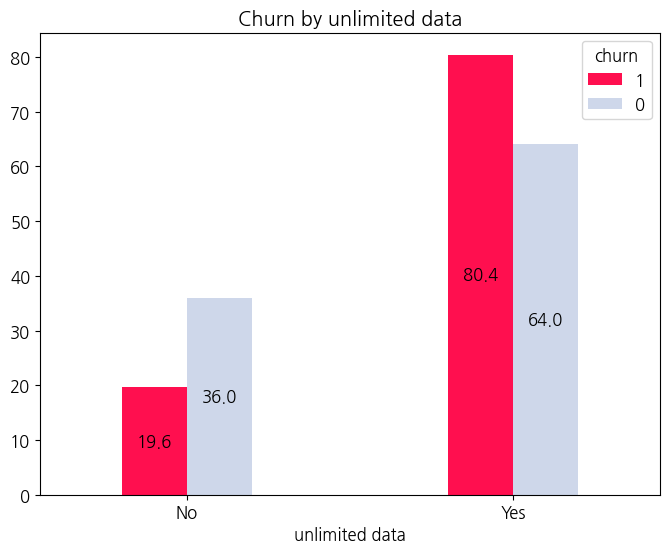

In [51]:
draw_pct_plot(unlimited_ptc, 'Churn by unlimited data', 'unlimited data', ['No', 'Yes'] )

#### 유지 고객이 더 많이 이용하는 서비스 
- **online_security**
- **online_backup**
- **device_protection**
- **tech_support**
- **premium_tech_support**

In [52]:
s1 = pd.concat([pivot_percent(churn_y, 'online_security'), pivot_percent(churn_n, 'online_security')], axis=1).drop([0], axis=0)
s2 = pd.concat([pivot_percent(churn_y, 'online_backup'), pivot_percent(churn_n, 'online_backup')], axis=1).drop([0], axis=0)
s3 = pd.concat([pivot_percent(churn_y, 'device_protection'), pivot_percent(churn_n, 'device_protection')], axis=1).drop([0], axis=0)
s4 = pd.concat([pivot_percent(churn_y, 'tech_support'), pivot_percent(churn_n, 'tech_support')], axis=1).drop([0], axis=0)
s5 = pd.concat([pivot_percent(churn_y, 'premium_tech_support'), pivot_percent(churn_n, 'premium_tech_support')], axis=1).drop([0], axis=0)

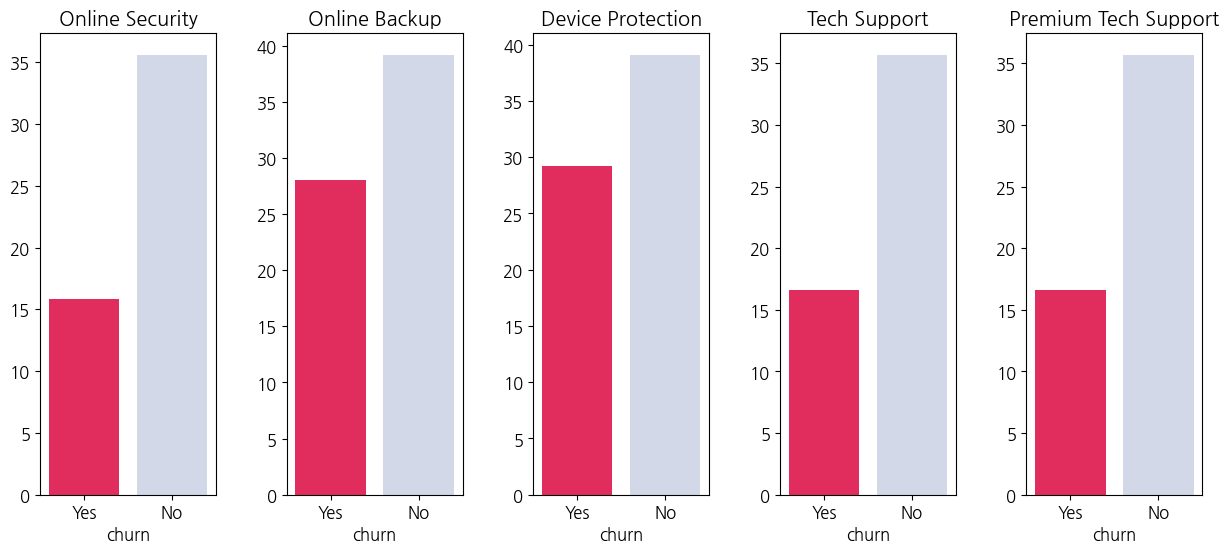

In [53]:
f, ax = plt.subplots(1, 5, figsize=(15, 6))
sns.barplot(s1, ax=ax[0], palette = ['#ff0f4f','#CED7EA'])
ax[0].set_title('Online Security')
ax[0].set_xticklabels(['Yes', 'No'])

sns.barplot(s2, ax=ax[1], palette = ['#ff0f4f','#CED7EA'])
ax[1].set_title('Online Backup')
ax[1].set_xticklabels(['Yes', 'No'])

sns.barplot(s3, ax=ax[2], palette = ['#ff0f4f','#CED7EA'])
ax[2].set_title('Device Protection')
ax[2].set_xticklabels(['Yes', 'No'])

sns.barplot(s4, ax=ax[3], palette = ['#ff0f4f','#CED7EA'])
ax[3].set_title('Tech Support')
ax[3].set_xticklabels(['Yes', 'No'])

sns.barplot(s5, ax=ax[4], palette = ['#ff0f4f','#CED7EA'])
ax[4].set_title('Premium Tech Support')
ax[4].set_xticklabels(['Yes', 'No'])

plt.subplots_adjust(wspace=0.4)  # 그래프 간격 조정

plt.show()

#### 이탈 고객이 더 많이 사용하는 서비스
- **internet_service**
- **streaming_tv**
- **streaming_movies**
- **streaming_music**
- **unlimited_data**

In [54]:
s6 = pd.concat([pivot_percent(churn_y, 'internet_service'), pivot_percent(churn_n, 'internet_service')], axis=1).drop([0], axis=0)
s7 = pd.concat([pivot_percent(churn_y, 'streaming_tv'), pivot_percent(churn_n, 'streaming_tv')], axis=1).drop([0], axis=0)
s8 = pd.concat([pivot_percent(churn_y, 'streaming_movies'), pivot_percent(churn_n, 'streaming_movies')], axis=1).drop([0], axis=0)
s9 = pd.concat([pivot_percent(churn_y, 'streaming_music'), pivot_percent(churn_n, 'streaming_music')], axis=1).drop([0], axis=0)
s10 = pd.concat([pivot_percent(churn_y, 'unlimited_data'), pivot_percent(churn_n, 'unlimited_data')], axis=1).drop([0], axis=0)


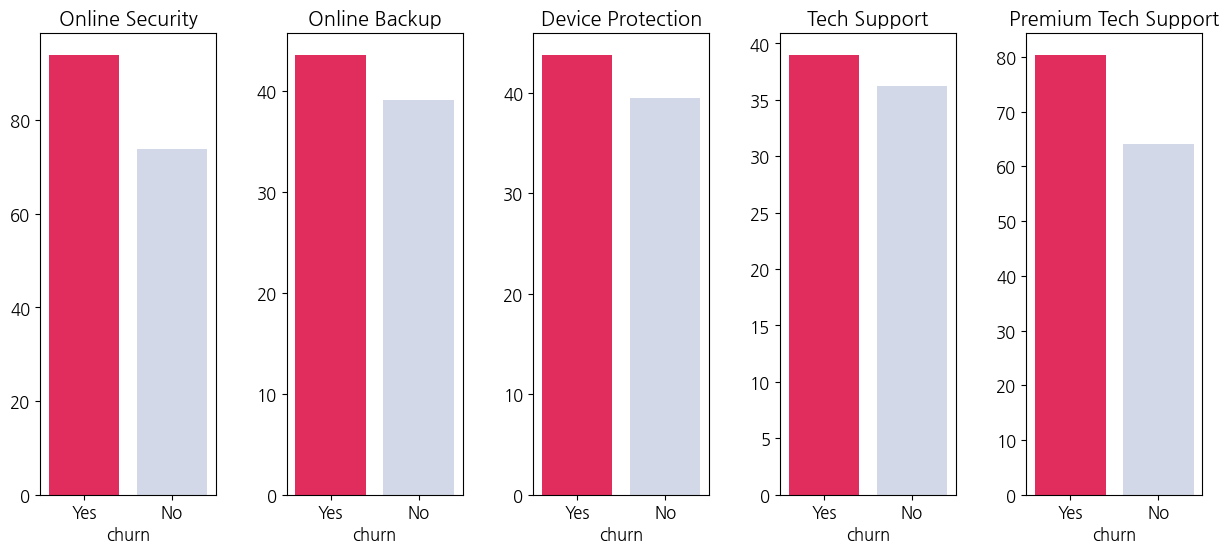

In [55]:
f, ax = plt.subplots(1, 5, figsize=(15, 6))
sns.barplot(s6, ax=ax[0], palette = ['#ff0f4f','#CED7EA'])
ax[0].set_title('Online Security')
ax[0].set_xticklabels(['Yes', 'No'])

sns.barplot(s7, ax=ax[1], palette = ['#ff0f4f','#CED7EA'])
ax[1].set_title('Online Backup')
ax[1].set_xticklabels(['Yes', 'No'])

sns.barplot(s8, ax=ax[2], palette = ['#ff0f4f','#CED7EA'])
ax[2].set_title('Device Protection')
ax[2].set_xticklabels(['Yes', 'No'])

sns.barplot(s9, ax=ax[3], palette = ['#ff0f4f','#CED7EA'])
ax[3].set_title('Tech Support')
ax[3].set_xticklabels(['Yes', 'No'])

sns.barplot(s10, ax=ax[4], palette = ['#ff0f4f','#CED7EA'])
ax[4].set_title('Premium Tech Support')
ax[4].set_xticklabels(['Yes', 'No'])

plt.subplots_adjust(wspace=0.4)  # 그래프 간격 조정

plt.show()

### 통신사 요금  


#### 통신 요금 데이터의 분포와 이상치를 파악 
Total Long Distance Charges와 Total Revenue 에 이상치가 확인된다


In [56]:
# Total 요금 관련 컬럼 추출 
charge_cols = [col for col in data.columns if ('total' in str(col).lower())]
charge_cols

['total_extraData_charges',
 'total_longDistance_charges',
 'total_charges',
 'total_refunds',
 'total_revenue']

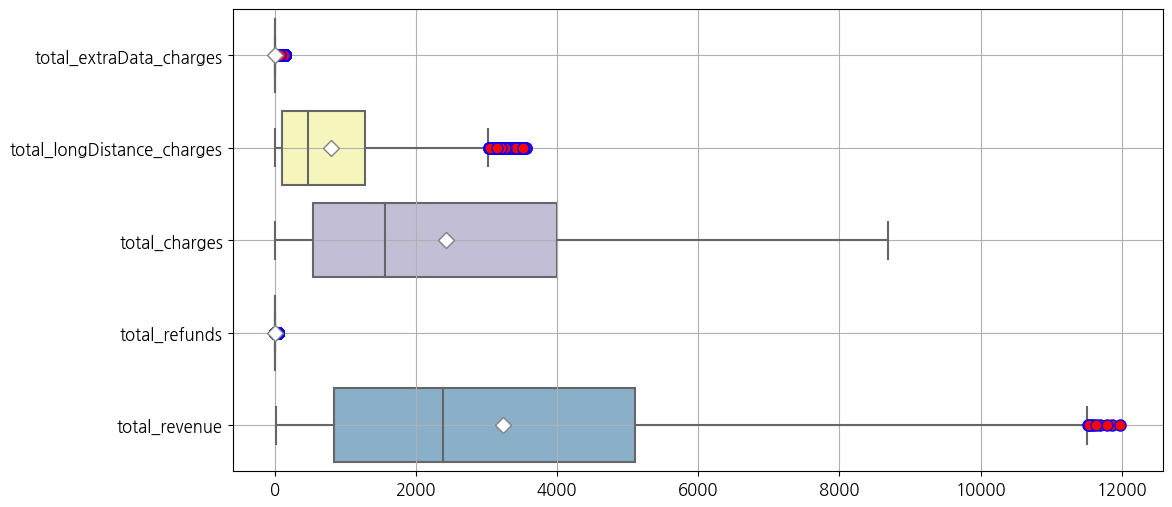

In [57]:
colors = sns.color_palette('Set3', n_colors=5)

plt.figure(figsize=(12,6))
sns.boxplot(data=data[charge_cols], orient='h', flierprops=dict(marker='o', markersize=8, markerfacecolor='red', markeredgecolor='blue'), # flierprops 이상치 표현 
            showmeans=True, meanprops=dict(marker='D', markerfacecolor='white',markeredgecolor='gray', markersize=8), palette=colors) # showmeans 평균값 

plt.grid()
plt.show()

#### Total Revenue , Total Long Distance Charges, Total Charges 에 따른 이탈 여부 
Total Revenue , Total Long Distance Charges, Total Charges 는 이상치가 심한 컬럼을 머신러닝의 주요 피처로 선택하는 것에 주의가 필요하다 . 


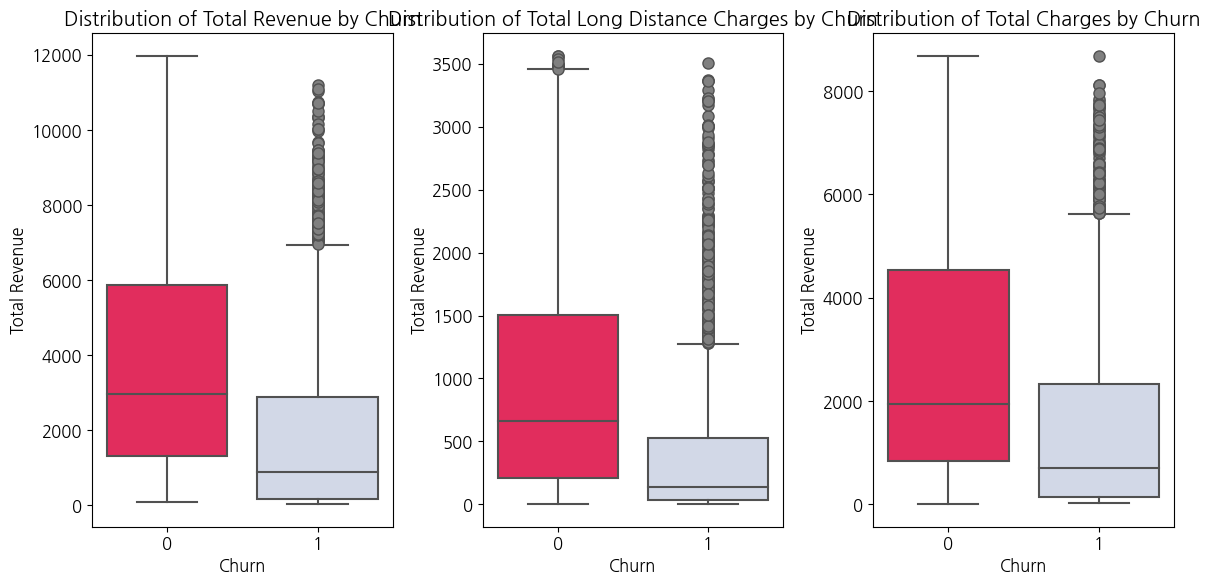

In [58]:
# Total Revenue 에 따른 이탈 여부 
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_revenue',
            flierprops=dict(marker='o', markersize=8, markerfacecolor='gray'),
            data=data,
            palette=['#ff0f4f', '#CED7EA'])

plt.xlabel('Churn')
plt.ylabel('Total Revenue')
plt.title('Distribution of Total Revenue by Churn')

# Total Long Distance Charges 에 따른 이탈 여부 
plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_longDistance_charges',
            flierprops=dict(marker='o', markersize=8, markerfacecolor='gray'),
            data=data,
            palette=['#ff0f4f', '#CED7EA'])

plt.xlabel('Churn')
plt.ylabel('Total Revenue')
plt.title('Distribution of Total Long Distance Charges by Churn')

# Total Charges 에 따른 이탈 여부 
plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_charges',
            flierprops=dict(marker='o', markersize=8, markerfacecolor='gray'),
            data=data,
            palette=['#ff0f4f', '#CED7EA'])

plt.xlabel('Churn')
plt.ylabel('Total Revenue')
plt.title('Distribution of Total Charges by Churn')



plt.tight_layout()
plt.show()

### 만족도 점수 
이탈 고객의 만족도는 낮은 편이다.


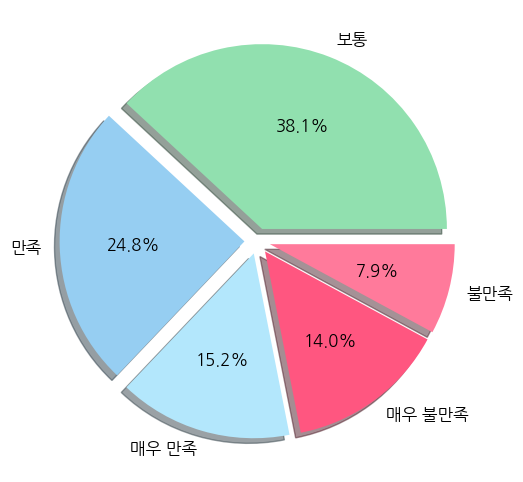

In [59]:
plt.figure(figsize = (8, 6))
plt.pie(get_percent(data, 'satisfaction_score'), 
        autopct='%.1f%%',
        labels=['보통', '만족', '매우 만족', '매우 불만족', '불만족'],
        colors=['#91e0af', '#96cef2', '#b3e7fc', '#ff5680', '#ff7a9b'],
        explode=[0.07, 0.07, 0.07, 0.07, 0.07],
        shadow=True)

plt.show()

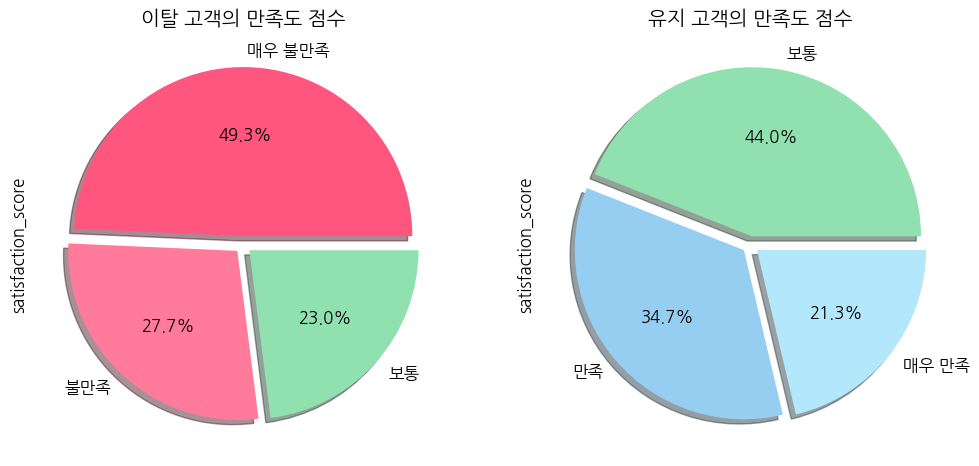

In [60]:
f,ax = plt.subplots(1,2,figsize=(12,6))
(get_percent(churn_y, 'satisfaction_score')).plot.pie(
    explode=[0.05, 0.05, 0.05],
    autopct='%1.1f%%',
    labels=['매우 불만족', '불만족', '보통'],
    colors=['#ff5680', '#ff7a9b', '#91e0af'],
    ax=ax[0],
    shadow=True
)
ax[0].set_title('이탈 고객의 만족도 점수')

(get_percent(churn_n, 'satisfaction_score')).plot.pie(
    explode=[0.05, 0.05, 0.05],
    autopct='%1.1f%%',
    labels=['보통', '만족', '매우 만족'],
    colors=['#91e0af', '#96cef2', '#b3e7fc'],
    ax=ax[1],
    shadow=True
)
ax[1].set_title('유지 고객의 만족도 점수')

plt.show()

### 고객 생애 가치 
유지 고객의 CLTV 점수가 높은 편이다. 이탈 고객 중에서도 CLTV 점수가 높은 고객이 있다.


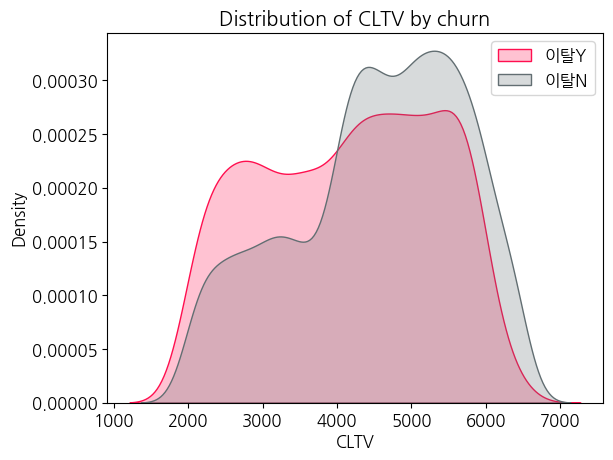

In [61]:
ax = sns.kdeplot(churn_y.CLTV, color="#ff0f4f", fill = True)
ax = sns.kdeplot(churn_n.CLTV, ax =ax, color="#626e72", fill= True)
ax.legend(["이탈Y","이탈N"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('CLTV')
ax.set_title('Distribution of CLTV by churn');

### 상관관계 분석

In [62]:
# 모델링에 불필요한 컬럼 삭제
data.drop(columns=['gender', 'age', 'referred_friend', 'referrals_num', 'offer', 'phone_service', 'multiple_lines',
                        'avg_monthly_GBdownload', 'avg_monthly_longDistance_charges', 'total_extraData_charges', 'payment_method', 'total_refunds',
                        'total_longDistance_charges', 'customer_status', 'churn_reason', 'churn_category', 'count', 'total_charges'], inplace=True)


# Churn 컬럼을 맨 마지막 컬럼으로 설정 
churn_df = data.pop('churn')  
data.insert(len(data.columns), 'churn', churn_df)  # 맨 마지막에 컬럼 삽입
data.head()


,under30,senior,dependents,married,contract,tenure,internet_service,online_security,online_backup,device_protection,...,streaming_movies,streaming_music,premium_tech_support,unlimited_data,monthly_charges,paperless_billing,total_revenue,satisfaction_score,CLTV,churn
0,0,0,0,0,1,2,1,1,1,0,...,0,0,0,1,53.85,1,129.09,1,3239,1
1,1,0,0,0,1,2,1,0,0,0,...,0,0,0,1,70.70,1,169.89,2,2701,1
2,0,0,0,0,1,8,1,0,0,1,...,1,1,0,1,99.65,1,917.70,3,5372,1
3,1,0,0,1,1,28,1,0,0,1,...,1,1,1,1,104.80,1,3182.97,3,5003,1
4,0,0,0,0,1,49,1,0,1,1,...,1,1,0,1,103.70,1,7208.47,1,5340,1


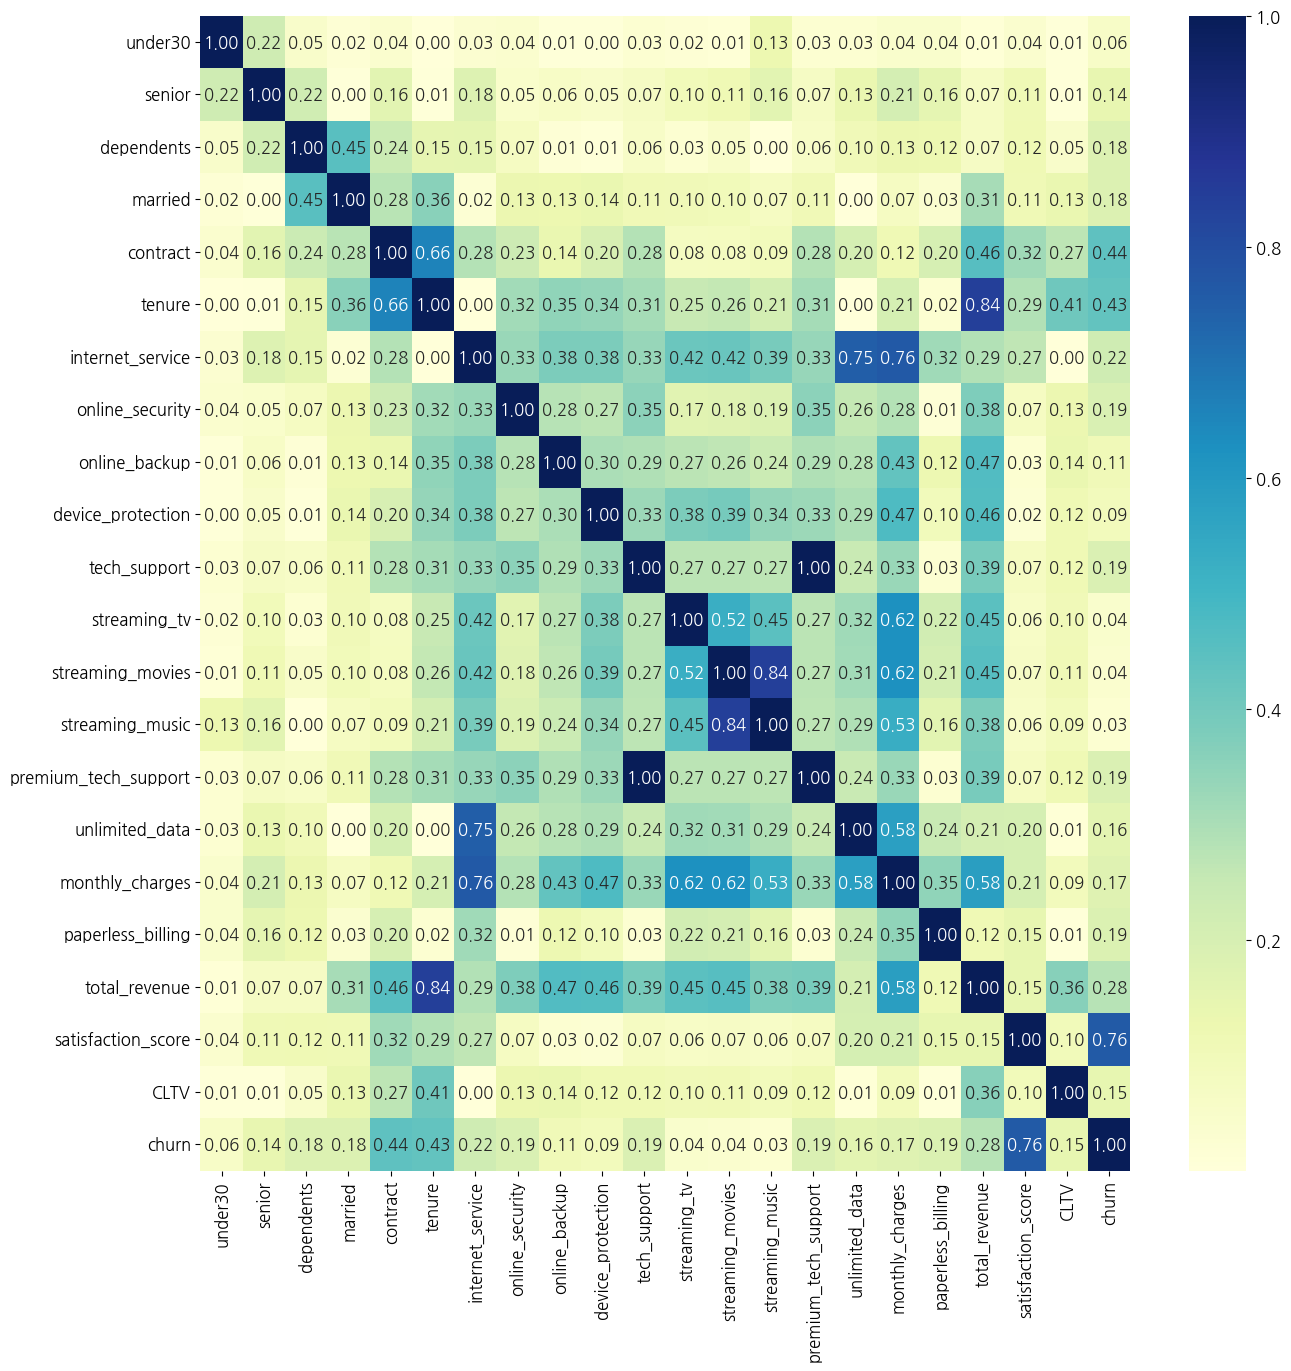

In [63]:
plt.figure(figsize=(15,15))
corr_matrix = data.corr(numeric_only=True).abs().round(6)
sns.heatmap(corr_matrix, cmap='YlGnBu', fmt=".2f", annot=True)
plt.show()

In [64]:
corr_matrix['churn'].sort_values(ascending = False).head(10)

churn                   1.000000
satisfaction_score      0.759986
contract                0.440867
tenure                  0.432950
total_revenue           0.278626
internet_service        0.224121
online_security         0.194545
premium_tech_support    0.187876
tech_support            0.187876
paperless_billing       0.187702
Name: churn, dtype: float64